# Lab Assignment: Linear Regression and High-Dimensional Data Analysis

1. **Loading and Visualizing the Dataset**:
   - Use the **California Housing** dataset to predict house prices based on various features such as **median income** and **number of households**.

   **Exercise**:
   - Load the dataset, visualize the first few rows, and plot the relationship between selected features and the target variable.

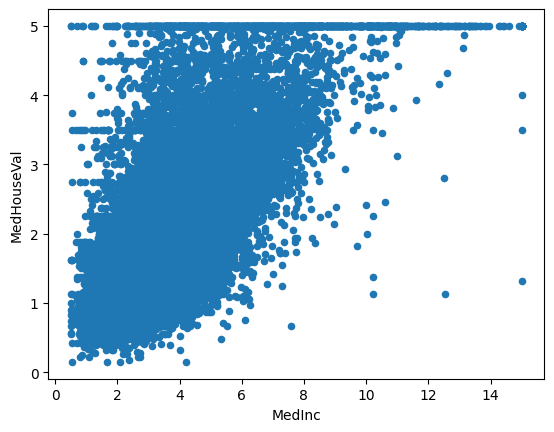

In [46]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import random
# Load the dataset
cali = fetch_california_housing(as_frame=True)
df = cali.frame

# Visualize data
df.plot(kind='scatter', x='MedInc', y='MedHouseVal')
plt.show()

2. **Implementing Linear Regression with Least Squares (Normal Equation)**:
   - Implement **Linear Regression** using the **Normal Equation**: $( \theta = (X^T X)^{-1} X^T y )$.
   - Use the dataset to solve for $( \theta )$ using matrix operations.

   **Exercise**:
   - Implement the normal equation method and calculate the parameters $( \theta )$.

In [47]:
import numpy as np

def least_squares(X, y):
	return np.linalg.inv((X.T @ X)) @ X.T @ y

# Prepare the data (add intercept term)
X = np.c_[np.ones(df.shape[0]), df['MedInc'].values]
y = df['MedHouseVal'].values

# Calculate theta
theta = least_squares(X, y)
print("Theta:", theta)


Theta: [0.45085577 0.41793849]


## Part 2: Linear Regression using SVD

1. **Using Singular Value Decomposition (SVD) for Linear Regression**:
   - Instead of using the normal equation, solve linear regression using **SVD**. This method is numerically more stable, especially for ill-conditioned or high-dimensional matrices.
   
   **Exercise**:
   - Implement linear regression using the **SVD** decomposition of the matrix \( X \).

In [48]:
a = np.asarray([[1, 0], [0, 2], [0, 0], [0, 0]])
a, np.linalg.pinv(a)

(array([[1, 0],
        [0, 2],
        [0, 0],
        [0, 0]]),
 array([[1. , 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. ]]))

In [50]:
def concatenate_zeros(a: np.ndarray, final_dim: int):
	zeros_below = np.zeros((final_dim - a.shape[0], a.shape[1]))
	return np.concatenate([a, zeros_below], axis=0)

In [51]:
def svd_least_squares(X: np.ndarray, y: np.ndarray):
	if y.ndim == 1:
		y = np.expand_dims(y, axis=-1)

	U, S, Vt = np.linalg.svd(X, full_matrices=True)
	# build the matrix S as in the svd decomposition
	S_full = concatenate_zeros(np.diag(S), X.shape[0])

	St= np.linalg.pinv(S_full)
	return Vt.T @ St @ U.T @ y


In [52]:
# Calculate theta using SVD
theta_svd = svd_least_squares(X, y)
print("Theta (SVD):", theta_svd)

Theta (SVD): [[0.45085577]
 [0.41793849]]


## Part 3: Shortcut (Scikit-learn)

1. **Introducing Scikit-learn's Linear Regression**:
   - Compare your manually implemented Linear Regression (Normal Equation and SVD) with the **Scikit-learn's Linear Regression** model. Use the built-in model for performance comparison.

   **Exercise**:
   - Use `sklearn.linear_model.LinearRegression` to solve the regression problem and compare the results.

In [53]:
from sklearn.linear_model import LinearRegression

# Todo
model = LinearRegression()
model.fit(X, y)
print("Scikit-learn coefficients:", model.coef_)

Scikit-learn coefficients: [0.         0.41793849]


## Part 4: Gradient Descent for Large Datasets

1. **Issues with Direct Methods on Large Datasets**:
   - Demonstrate the performance issue with the **Normal Equation** on very large datasets by creating synthetic data.

   **Exercise**:
   - Generate a large dataset and time the normal equation solution.

In [54]:
import time
from sklearn import datasets

# Generate large synthetic dataset
X_large, y_large, w_true = datasets.make_regression(
    n_samples=100000, # number of points
    n_features=1500, # number of features
    n_informative=1000, # number of informative features
    noise=1.0, # std of y
    bias=0, # bias for the model
    coef=True, # returning true coeffs
    random_state=2024
)

# Time the normal equation solution
start_time = time.time()
theta_large = least_squares(X_large, y_large)
print("Time taken by normal equation:", time.time() - start_time)

Time taken by normal equation: 3.870753765106201


In [62]:
np.mean(np.abs(theta_large - w_true))

0.002544494082704116

2. **Implementing Gradient Descent**:
   - Introduce **Batch Gradient Descent** as an alternative to handle large datasets efficiently.
   
   **Exercise**:
   - Implement gradient descent to solve the same problem iteratively.

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_large = scaler.fit_transform(X_large)

In [68]:
def mini_batch_gradient_descent(X: np.ndarray, 
                                y: np.ndarray, 
                                alpha=0.01, 
                                iterations=1000, 
                                batch_size=32):
	random.seed(0)
	np.random.seed(0)
	if y.ndim == 1:
		y = np.expand_dims(y, axis=-1)

	m, n = X.shape
	theta = np.random.rand(n, 1)
	for i in range(iterations):
		idx = np.random.choice(m, batch_size, replace=False)
		X_batch = X[idx]
		y_batch = y[idx]
		grad = (X_batch.T / (batch_size)) @ (X_batch @ theta - y_batch)
		# gradient = X_batch.T @ X_batch @ theta - X_batch.T @ y_batch
		theta = theta - alpha * grad
	return theta

def gradient_descent(X: np.ndarray, 
					y: np.ndarray, 
					alpha=0.01, 
					iterations=1000):
	random.seed(0)
	np.random.seed(0)
	if y.ndim == 1:
		y = np.expand_dims(y, axis=-1)

	m, n = X.shape
	theta = np.random.rand(n, 1)
	for i in range(iterations):
		grad = (X.T / m) @ (X @ theta - y)
		# gradient = X_batch.T @ X_batch @ theta - X_batch.T @ y_batch
		theta = theta - alpha * grad
	return theta

In [67]:
# Run Mini-Batch Gradient Descent
start_time = time.time()
theta_mbgd = mini_batch_gradient_descent(X_large, y_large, alpha=0.0001, iterations=1000, batch_size=512)
print("Time taken by Gradient Descent:", time.time() - start_time)
print("Difference from true values :", np.mean(abs(theta_mbgd-w_true)))

Time taken by Gradient Descent: 5.2388622760772705
Difference from true values : 33.27989220193131


In [72]:
start_time = time.time()
theta_gd = gradient_descent(X_large, y_large, alpha=0.01, iterations=500)
print("Time taken by Gradient Descent:", time.time() - start_time)
print("Difference from true values :", np.mean(abs(theta_gd-w_true)))

Time taken by Gradient Descent: 167.16087865829468
Difference from true values : 37.57639534803181


## Part 5: High-Dimensional Linear Regression

1. **Real-World Dataset with Many Features**:
   - Use a **real-world high-dimensional dataset** (e.g., **Gene Expression Data** or **1000 Genomes Dataset** from the UCI repository or Kaggle). A suitable high-dimensional dataset is the **"Arcene"** dataset (from UCI) with 10,000 features.

   **Exercise**:
   - Download [Arcane](https://archive.ics.uci.edu/dataset/167/arcene) dataset and apply linear regression to solve for $( \theta )$.

In [ ]:
# Load training data
arcene_data = pd.read_csv('arcene/ARCENE/arcene_train.data', sep=' ', header=None)
arcene_data = arcene_data.drop(columns=[10000])  # Remove last empty column

# Load training labels
arcene_labels = pd.read_csv('arcene/ARCENE/arcene_train.labels', sep=' ', header=None)

print("Shape of training data:", arcene_data.shape)
print("Shape of training labels:", arcene_labels.shape)

# Implement least squares on high-dimensional dataset
X_hd = arcene_data.values
y_hd = arcene_labels.values.ravel()

# Solve using normal equation
theta_hd = least_squares(X_hd, y_hd)
print("Theta for high-dimensional data:", theta_hd)

2. **Ridge Regression for High-Dimensional Data**:
   - Introduce **Ridge Regression (L2 Regularization)** as a solution to overfitting and multicollinearity in high-dimensional data.

   **Exercise**:
   - Implement Ridge Regression using the formula $( \theta = (X^T X + \lambda I)^{-1} X^T y )$.

In [ ]:
def ridge_regression(X, y, lambda_):
   m, n = X.shape
   I = np.eye(n)
   return np.linalg.inv(X.T @ X + lambda_ * I) @ X.T @ y

# Apply Ridge Regression
theta_ridge = ridge_regression(X_hd, y_hd, lambda_=0.1)
print("Theta (Ridge):", theta_ridge)

## Summary

1. **Linear Regression using different methods**: You implemented Linear Regression using the **Normal Equation**, **SVD**, and **Gradient Descent**.
2. **Comparison**: You compared the manual implementations with **scikit-learn’s** linear regression.
3. **High-Dimensional Data**: You applied linear regression techniques to a real-world **high-dimensional dataset** (Arcene) and explored how **Ridge Regression** can handle overfitting.